# <center>Project 2: Building a Student Intervention System</center>

## Supervised Learning Project
The goal for this project is to identify students who may need early intervention before they fail to graduate. 

# I. Classification vs. Regression
* *__Question 1__: Your goal is to identify students who might need early intervention - which type of supervised machine learning problem is this, classification or regression? Why?* 

This project explores **binary classification** because the goal is to identify (and classify) the students whom need intervention to prevent failure. Classification takes discrete class labels as inputs and evaluates a decision boundary. The evaluation is based on accuracy. 


# II. Exploring The Data
Data is divided between features and our target (passed). 



### We can make a number of observations simply off the dataset and some useful utilities including graduation rate:

Total number of students: 395

Number of features (excluding the target column): 30

Number of students who passed: 265

Number of students who failed: 130

Graduation rate of the class: 67.09%


1) Load the libraries

In [38]:
# Loading the libraries
# Import statements 
# Libraries
import numpy as np
import pandas as pd
import sklearn
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from time import time

# Libraries for metric functions
from sklearn.metrics import (f1_score, accuracy_score, make_scorer, fbeta_score, 
                             brier_score_loss, precision_score, recall_score)
from sklearn.metrics import classification_report, confusion_matrix

# Libraries used for classification models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn import neighbors
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

# Other utilities
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# Import functions from other python document
from student_functions import (preprocess_features,
                               plot_confusion_matrix,
                               plot_calibration_curve)

# Pretty display for notebooks
%matplotlib inline
from IPython.display import display

2) Load the student data from a CSV file and save as new dataframe @student_data

In [3]:
# Read student data
student_data = pd.read_csv("student-data.csv")
target = student_data['passed']
print "Student data read successfully!"

# create another dataframe for playing around with!
data = pd.read_csv('student-data.csv', header=0)
outcome_passed = data['passed']
outcome_passed_num = outcome_passed.replace(['yes', 'no'], [1,0])
features = data.drop('passed', axis = 1)
features_num = preprocess_features(features)

Student data read successfully!


3) Explore the data with some useful scikit learn utilities.
   - Print @student_data data type information
   - Print the first 3 indeces to get a feel for the features and data
   - List the keys of @student_data
   - Print descriptions of the features

In [4]:
# Returns information on @student_data data types 
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 31 columns):
school        395 non-null object
sex           395 non-null object
age           395 non-null int64
address       395 non-null object
famsize       395 non-null object
Pstatus       395 non-null object
Medu          395 non-null int64
Fedu          395 non-null int64
Mjob          395 non-null object
Fjob          395 non-null object
reason        395 non-null object
guardian      395 non-null object
traveltime    395 non-null int64
studytime     395 non-null int64
failures      395 non-null int64
schoolsup     395 non-null object
famsup        395 non-null object
paid          395 non-null object
activities    395 non-null object
nursery       395 non-null object
higher        395 non-null object
internet      395 non-null object
romantic      395 non-null object
famrel        395 non-null int64
freetime      395 non-null int64
goout         395 non-null int64
Dalc          395 no

In [5]:
# Printing first three indices
display(student_data.head(3))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes


In [6]:
# Printing the keys for @student_data
display(student_data.keys())

Index([u'school', u'sex', u'age', u'address', u'famsize', u'Pstatus', u'Medu',
       u'Fedu', u'Mjob', u'Fjob', u'reason', u'guardian', u'traveltime',
       u'studytime', u'failures', u'schoolsup', u'famsup', u'paid',
       u'activities', u'nursery', u'higher', u'internet', u'romantic',
       u'famrel', u'freetime', u'goout', u'Dalc', u'Walc', u'health',
       u'absences', u'passed'],
      dtype='object')

In [7]:
# Printing descriptions for the features set
# Using @features_num so we can get statistics for both quantitative and qualitative data
print(features_num.describe())

        school_GP   school_MS       sex_F       sex_M         age   address_R  \
count  395.000000  395.000000  395.000000  395.000000  395.000000  395.000000   
mean     0.883544    0.116456    0.526582    0.473418   16.696203    0.222785   
std      0.321177    0.321177    0.499926    0.499926    1.276043    0.416643   
min      0.000000    0.000000    0.000000    0.000000   15.000000    0.000000   
25%      1.000000    0.000000    0.000000    0.000000   16.000000    0.000000   
50%      1.000000    0.000000    1.000000    0.000000   17.000000    0.000000   
75%      1.000000    0.000000    1.000000    1.000000   18.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000   22.000000    1.000000   

        address_U  famsize_GT3  famsize_LE3   Pstatus_A     ...      \
count  395.000000   395.000000   395.000000  395.000000     ...       
mean     0.777215     0.711392     0.288608    0.103797     ...       
std      0.416643     0.453690     0.453690    0.305384  

### Features Ranked by SVM Weight in Relation to Target Variable @Passed
![Ranked Features](features_rank.png)

### With this output we can speculate a few things: 
- We are working with a pandas dataframe
- The dataframe is indexed 0 to 394
- There are **395 data entries** (rows) and **31 features** (columns)
    - Therefor, our dataframe is 395 rows x 31 columns
- Datatypes: there are 13 features of type int and 18 features which act as objects
- Student Ages
    - The oldest test subject is 22 and the youngest is 15
    - The average subject from the test was 17
- Absences
    - The maximum absences among the test subjects was 75 and the minimum was 0
    - The average from the test was 4

## Implementing the Data
The following section goes further in exploring the data by calculating a graduation rate for students among our data.
The new variables calculated are:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).

In [43]:
# Calculate number of students
n_students = student_data.shape[0]

# Calculate number of features
n_features = student_data.shape[1] - 1

# Calculate passing students
n_passed =len(student_data[student_data.passed == "yes"])

# Calculate failing students
n_failed = len(student_data[student_data.passed == "no"])

# Calculate graduation rate
grad_rate = float (n_passed) / n_students *100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


# Preparing the Data
This section involves preparing the data for modeling, training, and testing. 

## Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

*Seperating @student_data into feature and target columns:*

In [9]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1]

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
display(X_all.head())

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4


## Preprocess Feature Columns
As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. 

The code cell below will perform the preprocessing routine discussed. 

In [10]:
# @preprocess_features(X) is imported from student_functions.py

X_all = preprocess_features(X_all)
display("Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

# Check that features are preprocessed (if you want!)
# print X_all.head(3)

"Processed feature columns (48 total features):\n['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']"

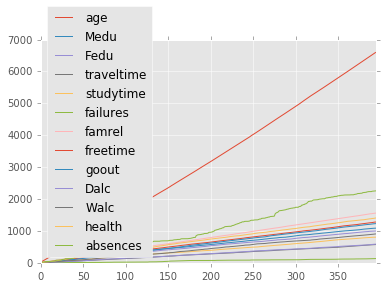

In [11]:
fig = features.cumsum()
fig.plot()

# Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [12]:
# Set the number of training points
# I decided to be more specific with my training points, calculating 75% of testing points and
# cast it to int so that the result is a whole number
num_train = int(n_students * 0.75)

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, 
                                                                     test_size=num_test, 
                                                                     train_size=num_train, 
                                                                     random_state=0)

# find a feature normalization: 
X_norm = np.mean(X_train, axis = 0)

# Show the results of the split
print "Features...."
print "Training set has {} samples with shape {}".format(X_train.shape[0], X_train.shape)
print "Testing set has {} samples with shape {}\n".format(X_test.shape[0], X_test.shape)
print "Labels..."
print "Training set has a shape of {}".format(y_train.shape)

Features....
Training set has 296 samples with shape (296, 48)
Testing set has 99 samples with shape (99, 48)

Labels...
Training set has a shape of (296,)


# IV. Training and Evaluating Models
This section identifies 3 supervised learning models that are appropriate for the problem and available in `scikit-learn`. 

Outline: 
1. Brief reasoning behind choosing my three models by considering what you know about the data and each model's strengths and weaknesses. 
2. Fit the models to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. 
3. Conclusive table showing the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

## Model Application: My Chosen Supervised Learning Models

* *__Question 2__: List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

### *Model A: Support Vector Machines*
[Support vector machines](http://scikit-learn.org/stable/modules/svm.html "Support Vector Machines") are a supervised learning technique that is often used for classiciation. Support Vector Machines (SVM's) can be used in the case of both classification and regression.

An SVM algorithm is used to calculate an optimal hyperplane by classifying training data into categorical functions. The algorithm then learns to assign new examples to a corresponding category of relating features. In this case we want to classify students into the two classes: those who passed and those who did not.

One can tune an SVM using parameters (including the all-mighty Kernel trick). An kernel can be applied to many function types including those which are non-linear and linear. A non-linear SVM can prove handy by generating a complex relationship among the data while reducing the upfront preprocessing in the data. As a downside, this process can take longer since it can be computationally exhaustive. 


The **strengths** of using SVMs are:
- Highly effective with large datasets
- Memory efficient
- Theoretical guarentees of performance
- Not affected by local minima
- Does not suffer from the *curse of dimensionality*
- Application versatality and ability to apply custom Kernel functions or the *Kernel trick* for domain knowledge

The **weaknesses** to using SVMs are: 
- Performs best when the number of samples is greater tan the number of features 
- Requires a developed kernel function
- Does not provide probability estimates directly

SVMs are often applied to solve problems of uncertainty and often applied in biological and other science. 

A Support Vector Machine is a reasonable choice for this data because `n < m`, that is the number of samples exceeds the number of features. We can also make justification for the SVC because of its ability to handle non-linear models without much end-user tuning. We can throw fairly complex data at it and in return get a rather strong model simple due its ability to transform the data and generate non-linear models. 

### *Model B: Nearest Neighbor*
The [nearest neighbor](http://scikit-learn.org/stable/modules/neighbors.html "Nearest Neighbors") algorithm offers a simple learning method for classification data using instance based learning. (Though it also can be used for unsupervised learning). KNN is described as a "lazy learner" as apposed to an "eager learner" because new data is compared to the training data to make a judgement as to if the instance fits; the data iteself is a function. 

In the case of our classification, the output is class membership: passed-yes/ passed-no. The model looks at the "k" nearest points to determine (by majority vote) which class the new point belongs. 

The **strengths** of using the nearest neighbor algorithm are:
- The simplicity of the model can be quick due to local approximation
- The cost of the learning process is minimal
- Accuracy increases and weights can be used to 'smooth' classifier

The **weakness** of using k-nearest neighbor are:
- Expense: The algorithm can be expensive when implementing on large datasets
- Results can be subject to bias and underfitting
- The curse of dimensionality is highly exibited in the model

KNN is most frequently used for classification problems including pattern recognition, DNA sequencing, and fraud detection. 

KNN is a reasonable choice for this data because we could organize the features and assign weights to feature importance. Because it measures distance, it can also be valuable to fit a non-linear classification. Since our dataset is intermediate, KNN is a good choice. 

### *Model C: Decision Tree*
A [decision tree](http://scikit-learn.org/stable/modules/tree.html "Decision Trees") model offers an intuitive method to split the data. DTs are often used as a reference before fitting a more complex model due to their speed. Because of their computational efficiency, it often lacks in being a strong performer otherwise and is prone to overfitting. 

The **benefits** of using a decision tree are: 
- Little computation required to perform classification on model
- Able to handle categorical and continuous variables
- Identify important features

The **weaknesses** of using a decision tree are: 
- Sensistivity to overfitting and underfitting data
- Bins may introduce bias
- May lack human reasoning or intuitive splitting
- Can be expensive for large datasets or for many features 
    - `cost = O(n^n)`

DTs are used in many environments. These learning algorithms can be used for portfolio theory in finance, game theory in statistics, DNA sequencing in molecular biology, and also in software development. 
    
A DT can be a reasonable choice for this data because it is computationaly efficient. The model is less complex and can be more simple to understand and interpret.  

## Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [13]:
# Functions for training and testing
# As per udacity guidelines :)

def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    train_time = end - start
    
    # Print the results
    print "Trained model in \t\t\t{:.4f}".format(train_time)
    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in \t\t\t{:.4f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: \t\t{:.4f}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: \t\t\t{:.4f}".format(predict_labels(clf, X_test, y_test))

In [14]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Functions for training and testing
# Functions perform same operations as the above functions but also identify variables for inbetween steps
# @ train_classifier_noP: stands for train classifier no print


def train_classifier_noP(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock, return the time it takes
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Store and return results
    train_time = end - start # variable @train_time
    return train_time # return variable @train_time: the time it takes to fit/ train the model

def predict_labels_noP(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    # Start the clock, make predictions, then stop the clock, return the time it takes with f1 scores
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Store calculated variables
    # variable @predict_time
    predict_time = end - start 
    # variable @predict_f1_score
    predict_f1_score = f1_score(target.values, y_pred, pos_label='yes')
    
    # return variables @predict_time and @predict_f1_score
    return predict_time, predict_f1_score


def train_predict_noP(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Training time
    tc = train_classifier_noP(clf, X_train, y_train)
    
    # Training set
    pl_1 = predict_labels_noP(clf, X_train, y_train)
    
    # Test set
    pl_2 = predict_labels_noP(clf, X_test, y_test)
    
    return tc, pl_1[0], pl_1[1], pl_2[0], pl_2[1]


def train_predict_print(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score, 
    format and print the results. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    tc = train_classifier_noP(clf, X_train, y_train)
    print "Trained model in \t\t\t\t\t{:.4f}".format(tc)
    
    # Training set
    pl_1 = predict_labels_noP(clf, X_train, y_train)
    print "Made predictions on training set in: \t\t\t{:.4f}".format(pl_1[0])
    print "F1 score for training set: \t\t\t\t{:.4f}".format(pl_1[1])
    
    # Test set
    pl_2 = predict_labels_noP(clf, X_test, y_test)
    print "Made predictions on test set in: \t\t\t{:.4f}".format(pl_2[0])
    print "F1 score for test set: \t\t\t\t\t{:.4f}".format(pl_2[1])

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [44]:
# Already imported ----
# from sklearn.svm import SVC
# from sklearn import neighbors
# from sklearn import tree
# from sklearn.metrics import accuracy_score
# ----

# Classifier A: Support Vector Machine Algorithm
a = "Support Vector Machine"
# Classifier B: Nearest Neighbor Algorithm
b = "Nearest Neighbor Algorithm"
# Classifier C: Decision Tree Algorithm
c = "Decision Tree Algorithm"
# Classifier D: Logistic Regression
d = "Logistic Regression"


# Initialize the three models
clf_A = SVC(kernel='linear', random_state=0)
clf_B = neighbors.KNeighborsClassifier()
clf_C = tree.DecisionTreeClassifier(random_state=0)
clf_D = LogisticRegression(random_state=0)
clf_E = GaussianNB()


# Set up the training set sizes
X_train_100 = X_train[:100]
y_train_100 = y_train[:100]

X_train_200 = X_train[:200]
y_train_200 = y_train[:200]

X_train_300 = X_train[:300]
y_train_300 = y_train[:300]

In [45]:
# Execute the 'train_predict' function for each classifier and each training set size

def train_pred_all(clf):
    '''train and predict a model on ALL training sizes'''
    my100 = train_predict_print(clf, X_train_100, y_train_100, X_test, y_test)
    #print my100
    print
    my200 = train_predict_print(clf, X_train_200, y_train_200, X_test, y_test)
    #print my200
    print
    my300 = train_predict_print(clf, X_train_300, y_train_300, X_test, y_test)
    #print my300
    print


def clf_stats_all(clf, clf_info):
    '''Get and print calculated statistics for a model'''
    print "Statistics for {} model. . .".format(clf.__class__.__name__)
    print "Mean training time: {:,.4f}".format(np.mean(clf_info[0]))
    print "Mean prediction time: {:,.4f}".format(np.mean(clf_info[1]))
    print "Mean F1 score for training sets: {:,.4f}".format(np.mean(clf_info[2]))
    print "Mean testing time: {:,.4f}".format(np.mean(clf_info[3]))
    print "Mean F1 score for test sets: {:,.4f}".format(np.mean(clf_info[4]))

In [46]:
def clf_report(clf):
    '''Calculates classification report for a model'''
    print "\nClassification Report!"
    print classification_report(y_test, clf.predict(X_test))


def plot_mat(clf):
    '''Computes confusion matrix with and without normalization'''
    # Compute confusion matrix
    #fig = plt.figure()
    cm = confusion_matrix(y_test, clf.predict(X_test), labels=["yes","no"])
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm)

    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

    plt.show()

### *Support Vector Machine:*
Model performance for training sets of sizes 95, 195, and 295.

Support Vector Machines (SVM's) can be used in the case of both classification and regression. In the case of classification, an SVM can be prove helpful when the data is linearly seperatable. An SVM algorithm can go further to seperate the data into vectors by means of a kernel where a decision surface is maximized to distinguish differences within features and classes. 

Training a SVC using a training set size of 100. . .
Trained model in 					0.0098
Made predictions on training set in: 			0.0009
F1 score for training set: 				0.8397
Made predictions on test set in: 			0.0012
F1 score for test set: 					0.7353

Training a SVC using a training set size of 200. . .
Trained model in 					0.0350
Made predictions on training set in: 			0.0029
F1 score for training set: 				0.8345
Made predictions on test set in: 			0.0020
F1 score for test set: 					0.7465

Training a SVC using a training set size of 296. . .
Trained model in 					0.0332
Made predictions on training set in: 			0.0050
F1 score for training set: 				0.8456
Made predictions on test set in: 			0.0022
F1 score for test set: 					0.7887


-----------------------------------------------
Statistics for SVC model. . .
Mean training time: 0.0043
Mean prediction time: 0.0031
Mean F1 score for training sets: 0.8742
Mean testing time: 0.0015
Mean F1 score for test sets: 0.7702
-------------------------

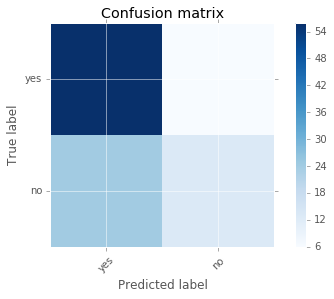

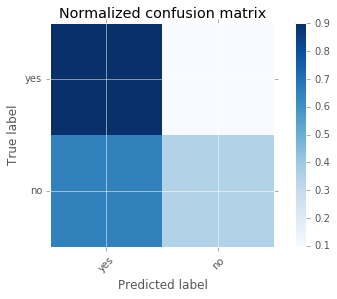

In [47]:
# Run functions for @clf_A - Support Vector Machine
# Train and predict @clf_A on training ALL predefined trainng set sizes
train_pred_all(clf_A)



clf_A_arr = [train_predict_noP(clf_A, X_train_100, y_train_100, X_test, y_test),
             train_predict_noP(clf_A, X_train_200, y_train_200, X_test, y_test),
             train_predict_noP(clf_A, X_train_300, y_train_300, X_test, y_test)]


# Create array of models results
clf_A_info = [[0.0017, 0.0039, 0.0073],
              [0.0009, 0.0028, 0.0055],
              [0.8759, 0.8759, 0.8707],
              [0.0008, 0.0008, 0.0030],
              [0.7712, 0.7712, 0.7682]]

print "\n-----------------------------------------------"
# Print mean results over thee three training sets
clf_stats_all(clf_A, clf_A_info)
print "-----------------------------------------------"


# Print classification report
clf_report(clf_A)

# Print confusion matrix and plot
plot_mat(clf_A)

In [48]:
clf_A.n_support_

array([83, 97], dtype=int32)

### *K Nearest Neighbor Classifier:*
Model performance for training sets of sizes 95, 195, and 295.

Training a KNeighborsClassifier using a training set size of 100. . .
Trained model in 					0.0017
Made predictions on training set in: 			0.0039
F1 score for training set: 				0.7857
Made predictions on test set in: 			0.0016
F1 score for test set: 					0.7429

Training a KNeighborsClassifier using a training set size of 200. . .
Trained model in 					0.0008
Made predictions on training set in: 			0.0038
F1 score for training set: 				0.8622
Made predictions on test set in: 			0.0025
F1 score for test set: 					0.6957

Training a KNeighborsClassifier using a training set size of 296. . .
Trained model in 					0.0011
Made predictions on training set in: 			0.0071
F1 score for training set: 				0.8719
Made predictions on test set in: 			0.0028
F1 score for test set: 					0.7448


-----------------------------------------------
Statistics for KNeighborsClassifier model. . .
Mean training time: 0.0011
Mean prediction time: 0.0051
Mean F1 score for training sets: 0.8379
Mean testing time: 

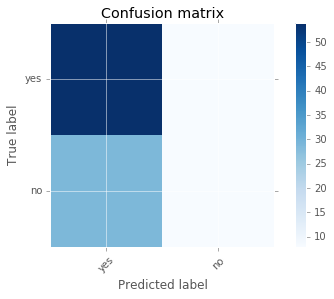

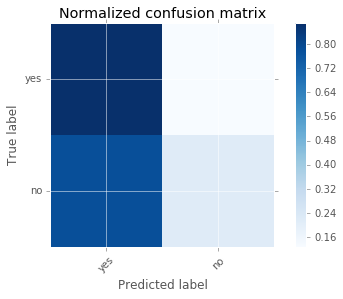

In [49]:
# Run functions for @clf_B - K Nearest Neighbor Classifier
# Train and predict @clf_B on training ALL predefined trainng set sizes
train_pred_all(clf_B)

# Create array of models results
clf_B_info = [[0.0012, 0.0007, 0.0014],
              [0.0024, 0.0037, 0.0093],
              [0.7812, 0.8592, 0.8733],
              [0.0015, 0.0034, 0.0091],
              [0.7338, 0.7183, 0.7448]]

print "\n-----------------------------------------------"
# Print mean results over thee three training sets
clf_stats_all(clf_B, clf_B_info)
print "-----------------------------------------------"

# Print classification report
clf_report(clf_B)

# Print confusion matrix and plot
plot_mat(clf_B)

## *Decision Tree Classifier:*
Model performance for training sets of sizes 95, 195, and 295.

Training a DecisionTreeClassifier using a training set size of 100. . .
Trained model in 					0.0020
Made predictions on training set in: 			0.0004
F1 score for training set: 				1.0000
Made predictions on test set in: 			0.0003
F1 score for test set: 					0.7000

Training a DecisionTreeClassifier using a training set size of 200. . .
Trained model in 					0.0019
Made predictions on training set in: 			0.0004
F1 score for training set: 				1.0000
Made predictions on test set in: 			0.0005
F1 score for test set: 					0.6917

Training a DecisionTreeClassifier using a training set size of 296. . .
Trained model in 					0.0025
Made predictions on training set in: 			0.0004
F1 score for training set: 				1.0000
Made predictions on test set in: 			0.0003
F1 score for test set: 					0.7500


-----------------------------------------------
Statistics for DecisionTreeClassifier model. . .
Mean training time: 0.0018
Mean prediction time: 0.0003
Mean F1 score for training sets: 1.0000
Mean testin

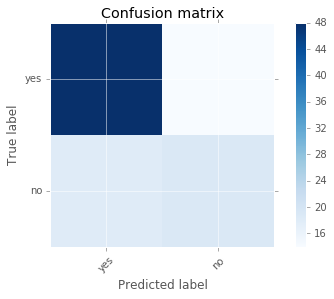

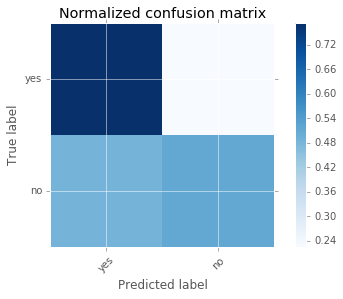

In [50]:
# Run functions for @clf_C - Decision Tree Classifier
# Train and predict @clf_C on training ALL predefined trainng set sizes
train_pred_all(clf_C)

# Create array of models results
clf_C_info = [[0.0019, 0.0015, 0.0021],
              [0.0004, 0.0002, 0.0003],
              [1.0, 1.0, 1.0,],
              [0.0003, 0.0003, 0.0003],
              [0.7302, 0.7259, 0.7500]]

print "\n-----------------------------------------------"
# Print mean results over thee three training sets
clf_stats_all(clf_C, clf_C_info)
print "-----------------------------------------------"

# Print classification report
clf_report(clf_C)

# Print confusion matrix and plot
plot_mat(clf_C)

### Logistic Regression: 
Model performance for training sets of sizes 95, 195, 295.

In [51]:
# Run functions for @clf_D - Logistic Regression
# Train and predict @clf_D on training ALL predefined trainng set sizes
train_pred_all(clf_D)

# Create array of models results
clf_D_info = [[0.0021, 0.0002, 0.0040],
              [0.0005, 0.0003, 0.0004],
              [0.8346, 0.8333, 0.8421,],
              [0.0002, 0.0005, 0.0002],
              [0.7259, 0.7714, 0.7801]]

print "\n-----------------------------------------------"
# Print mean results over thee three training sets
clf_stats_all(clf_D, clf_D_info)
print "-----------------------------------------------"

# Print classification report
clf_report(clf_D)

Training a LogisticRegression using a training set size of 100. . .
Trained model in 					0.0022
Made predictions on training set in: 			0.0005
F1 score for training set: 				0.8000
Made predictions on test set in: 			0.0002
F1 score for test set: 					0.7153

Training a LogisticRegression using a training set size of 200. . .
Trained model in 					0.0020
Made predictions on training set in: 			0.0003
F1 score for training set: 				0.8269
Made predictions on test set in: 			0.0005
F1 score for test set: 					0.7770

Training a LogisticRegression using a training set size of 296. . .
Trained model in 					0.0039
Made predictions on training set in: 			0.0004
F1 score for training set: 				0.8474
Made predictions on test set in: 			0.0003
F1 score for test set: 					0.7801


-----------------------------------------------
Statistics for LogisticRegression model. . .
Mean training time: 0.0021
Mean prediction time: 0.0004
Mean F1 score for training sets: 0.8367
Mean testing time: 0.0003
M

### *Gaussian Naive Bayes:*
Model performance for training sets of sizes 95, 195, and 295.

In [52]:

train_pred_all(clf_E)

# Create array of models results
clf_E_info = [[0.0023, 0.0010, 0.0015],
              [0.0008, 0.0005, 0.0006],
              [0.8387, 0.8417, 0.8131,],
              [0.0004, 0.0004, 0.0004],
              [0.7391, 0.7391, 0.7465]]

print "\n-----------------------------------------------"
# Print mean results over thee three training sets
clf_stats_all(clf_E, clf_E_info)
print "-----------------------------------------------"

# Print classification report
clf_report(clf_E)


Training a GaussianNB using a training set size of 100. . .
Trained model in 					0.0025
Made predictions on training set in: 			0.0006
F1 score for training set: 				0.8217
Made predictions on test set in: 			0.0004
F1 score for test set: 					0.7299

Training a GaussianNB using a training set size of 200. . .
Trained model in 					0.0011
Made predictions on training set in: 			0.0005
F1 score for training set: 				0.8315
Made predictions on test set in: 			0.0004
F1 score for test set: 					0.7111

Training a GaussianNB using a training set size of 296. . .
Trained model in 					0.0020
Made predictions on training set in: 			0.0008
F1 score for training set: 				0.8120
Made predictions on test set in: 			0.0004
F1 score for test set: 					0.7465


-----------------------------------------------
Statistics for GaussianNB model. . .
Mean training time: 0.0016
Mean prediction time: 0.0006
Mean F1 score for training sets: 0.8312
Mean testing time: 0.0004
Mean F1 score for test sets: 0.74

## Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

### <center>Classifer 1 - Support Vector Machine</center>

| Training Set Size | Training Time | Prediction Time (test) | F<sub>1</sub> Score (train) | F<sub>1</sub> Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 95                |      0.0017             |           0.0009       |    0.8759        |         0.7712  |
| 195               |        0.0039           |            0.0015      |    0.8716        |    0.7712       |
| 295               |       0.0076            |          0.0019        |    0.8707        |    0.7682       |
| **MEAN**          |     *0.0043*            |    *0.0015*            |   *0.8742*       |     *0.7702*    |

### <center>Classifer 2 - K Nearest Neighbor Classifier</center>

| Training Set Size | Training Time | Prediction Time (test) | F<sub>1</sub> Score (train) | F<sub>1</sub> Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
|95                 |       0.0016            |    0.0014              |   0.7812         |     0.7338      |
| 195               |     0.0010              |    0.0020              |   0.8592         |     0.7183      |
| 295               |       0.0009            |    0.0027              |   0.8733         |     0.7448      |
| **MEAN**          |       *0.0011*          |    *0.0047*            |   *0.8379*       |    *0.7323*     |

### <center>Classifer 3 - Decision Tree Classifier</center>

| Training Set Size | Training Time | Prediction Time (test) | F<sub>1</sub> Score (train) | F<sub>1</sub> Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 195               |          0.0018         |         0.0002         |      1.0000      |     0.7302      |
| 195               |          0.0014         |         0.0002         |      1.0000      |     0.7259      |
| 195               |          0.0029         |         0.0003         |      1.0000      |     0.7534      |
| **MEAN**          |       *0.0018*          |    *0.0003*            |   *1.0000*       |    *0.7323*     |

### <center>Classifer 4 - Linear Regression Classifier</center>

| Training Set Size | Training Time | Prediction Time (test) | F<sub>1</sub> Score (train) | F<sub>1</sub> Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 95               |          0.0025         |         0.0003         |      0.8346      |     0.7259      |
| 195               |          0.0019         |         0.0004         |      0.8333      |     0.7714      |
| 295               |          0.0039         |         0.0002         |      0.8421      |     0.7176      |
| **MEAN**          |       *0.0028*          |    *0.0003*            |   *0.8367*       |    *0.7383*     |

### <center>Classifer 5 - Guassian Naive Bayes</center>

| Training Set Size | Training Time | Prediction Time (test) | F<sub>1</sub> Score (train) | F<sub>1</sub> Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 95               |          0.0022         |         0.0004         |      0.8387      |     0.7391      |
| 195               |          0.0013         |         0.0005         |      0.8417      |     0.7111      |
| 295               |          0.0015         |         0.0006         |      0.8131      |     0.7651      |
| **MEAN**          |       *0.0016*          |    *0.0003*            |   *0.8312*       |    *0.7384*     |

### Compare classifiers by their means
Comparing the classifiers by their aggregated averages over all three sample sizes we can gauge the models fit in terms of speed and strength.

In [53]:
def get_comparison_info(name, i):
    '''Computes and prints mean results by training size to compare models'''
    print name
    print "\tSVC: \t\t\t\t{:,.4f}".format(np.mean(clf_A_info[i]))
    print "\tKNN: \t\t\t\t{:,.4f}".format(np.mean(clf_B_info[i]))
    print "\tDT: \t\t\t\t{:,.4f}".format(np.mean(clf_C_info[i]))
    print "\tLR: \t\t\t\t{:,.4f}".format(np.mean(clf_D_info[i]))
    print "\tNB: \t\t\t\t{:,.4f}".format(np.mean(clf_E_info[i]))


get_comparison_info("Mean Training Time:", 1)
print "\tLowest mean training time: \n\t=> Decision Tree\n"
get_comparison_info("Mean Prediction Time for Training Set:", 1)
print "\tLowest mean prediction time for training: \n\t=> Decision tree\n"
get_comparison_info("Mean F1 Score for Training Set:", 2)
print "\tHighest mean F1 score for training: \n\t=> SVC*\n"
get_comparison_info("Mean Prediction Time for Test Set:", 3)
print "\tLowest mean prediction time for testing: \n\t=> DT, LR\n"
get_comparison_info("Mean F1 Score for Test Set:", 4)
print "\tHighest mean F1 score for testing: \n\t=> SVC"

Mean Training Time:
	SVC: 				0.0031
	KNN: 				0.0051
	DT: 				0.0003
	LR: 				0.0004
	NB: 				0.0006
	Lowest mean training time: 
	=> Decision Tree

Mean Prediction Time for Training Set:
	SVC: 				0.0031
	KNN: 				0.0051
	DT: 				0.0003
	LR: 				0.0004
	NB: 				0.0006
	Lowest mean prediction time for training: 
	=> Decision tree

Mean F1 Score for Training Set:
	SVC: 				0.8742
	KNN: 				0.8379
	DT: 				1.0000
	LR: 				0.8367
	NB: 				0.8312
	Highest mean F1 score for training: 
	=> SVC*

Mean Prediction Time for Test Set:
	SVC: 				0.0015
	KNN: 				0.0047
	DT: 				0.0003
	LR: 				0.0003
	NB: 				0.0004
	Lowest mean prediction time for testing: 
	=> DT, LR

Mean F1 Score for Test Set:
	SVC: 				0.7702
	KNN: 				0.7323
	DT: 				0.7354
	LR: 				0.7591
	NB: 				0.7416
	Highest mean F1 score for testing: 
	=> SVC


In [54]:
print "Support Vector Machine Scores..."
print "Train accuracy %f" %clf_A.score(X_train,y_train)
print "Test accuracy %f"%clf_A.score(X_test,y_test)

print "\nNearest Neighbor Classifier..."
print "Train accuracy %f" %clf_B.score(X_train,y_train)
print "Test accuracy %f"%clf_B.score(X_test,y_test)

print"\nDecision Tree Classifier..."
print "Train accuracy %f" %clf_C.score(X_train,y_train)
print "Test accuracy %f"%clf_C.score(X_test,y_test)

print"\nLinear Regression Classifier..."
print "Train accuracy %f" %clf_D.score(X_train,y_train)
print "Test accuracy %f"%clf_D.score(X_test,y_test)

print"\nNaive Bayes Classifier..."
print "Train accuracy %f" %clf_E.score(X_train,y_train)
print "Test accuracy %f"%clf_E.score(X_test,y_test)

Support Vector Machine Scores...
Train accuracy 0.766892
Test accuracy 0.696970

Nearest Neighbor Classifier...
Train accuracy 0.807432
Test accuracy 0.626263

Decision Tree Classifier...
Train accuracy 1.000000
Test accuracy 0.676768

Linear Regression Classifier...
Train accuracy 0.773649
Test accuracy 0.686869

Naive Bayes Classifier...
Train accuracy 0.746622
Test accuracy 0.636364


## Probability Calibration Curves

Looking at our various classification models, we can predict not only the class label but also the associated probability. 

Code sourced and adapted from scikit-learn documentation: http://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#example-calibration-plot-calibration-curve-py

Automatically created module for IPython interactive environment


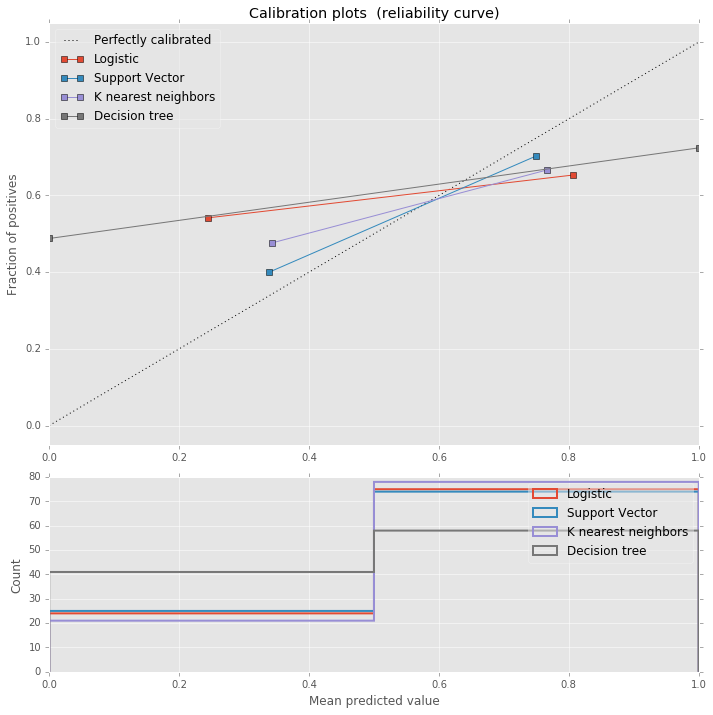

In [55]:
print(__doc__)

# Adapted from scikit learn documentation
# Author: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

# Create instances of training and testing data
# For simplicity purposes, I choose to use a training size of 95 and 
# mirror the test/ training data
X_train_cal = X_train_100
X_test_cal = X_test
y_train_cal = y_train_100
y_test_cal = y_test

# Create classifiers
clf_lr = LogisticRegression() # Threw in a regression model as baseline
clf_svc = SVC(random_state=0)
clf_knn = neighbors.KNeighborsClassifier()
clf_tree = tree.DecisionTreeClassifier(random_state=0)
gnb = GaussianNB()
#rfc = RandomForestClassifier(n_estimators=100)


###############################################################################
# Plot calibration plots

plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
for clf, name in [(clf_lr, 'Logistic'),
                  (clf_svc, 'Support Vector'),
                  (clf_knn, 'K nearest neighbors'),
                  (clf_tree, 'Decision tree')]:
    clf.fit(X_train_cal, y_train_cal)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # use decision function
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=2)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name))

    ax2.hist(prob_pos, range=(0, 1), bins=2, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc='best', fancybox=True, framealpha=0.5)
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc='best', fancybox=True, framealpha=0.5)

plt.tight_layout()
plt.show()

Automatically created module for IPython interactive environment
Logistic:
	Brier: 0.270
	Precision: 0.654
	Recall: 0.823
	F1: 0.729

Naive Bayes:
	Brier: 0.339
	Precision: 0.667
	Recall: 0.806
	F1: 0.730

Naive Bayes + Isotonic:
	Brier: 0.230
	Precision: 0.655
	Recall: 0.919
	F1: 0.765

Naive Bayes + Sigmoid:
	Brier: 0.229
	Precision: 0.626
	Recall: 1.000
	F1: 0.770

Logistic:
	Brier: 0.270
	Precision: 0.654
	Recall: 0.823
	F1: 0.729

SVC:
	Brier: 0.249
	Precision: 0.649
	Recall: 0.806
	F1: 0.719

SVC + Isotonic:
	Brier: 0.232
	Precision: 0.686
	Recall: 0.952
	F1: 0.797

SVC + Sigmoid:
	Brier: 0.230
	Precision: 0.624
	Recall: 0.935
	F1: 0.748

Logistic:
	Brier: 0.270
	Precision: 0.654
	Recall: 0.823
	F1: 0.729

KNN:
	Brier: 0.239
	Precision: 0.667
	Recall: 0.839
	F1: 0.743

KNN + Isotonic:
	Brier: 0.230
	Precision: 0.626
	Recall: 1.000
	F1: 0.770

KNN + Sigmoid:
	Brier: 0.230
	Precision: 0.626
	Recall: 1.000
	F1: 0.770

Logistic:
	Brier: 0.270
	Precision: 0.654
	Recall: 0.823
	F1: 0.7

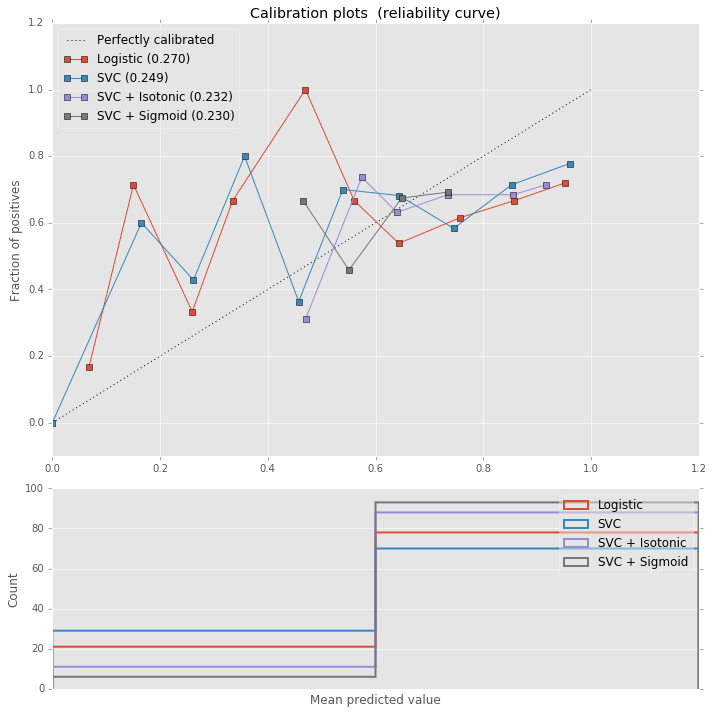

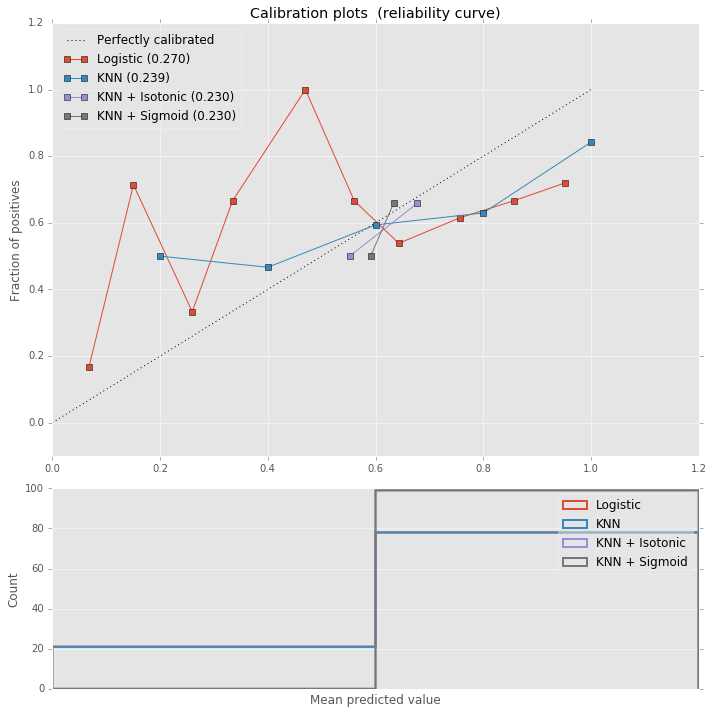

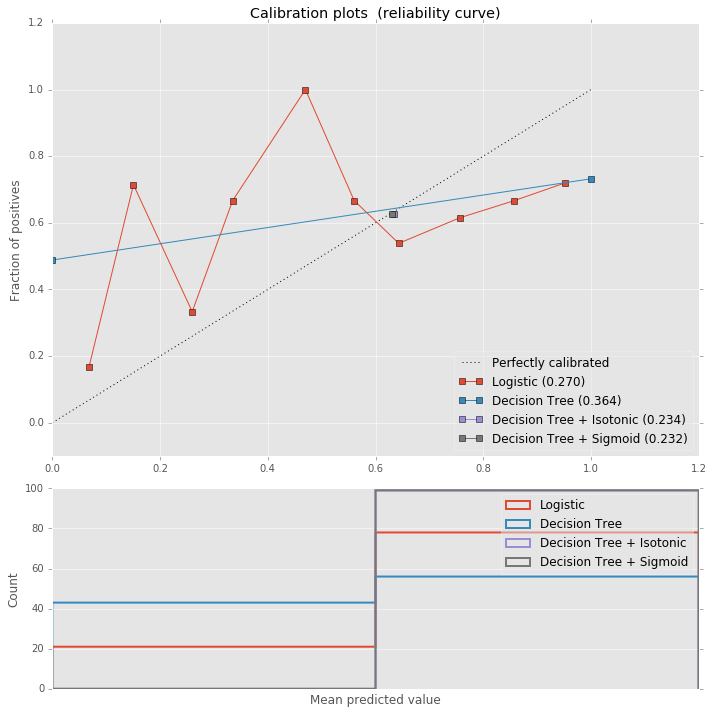

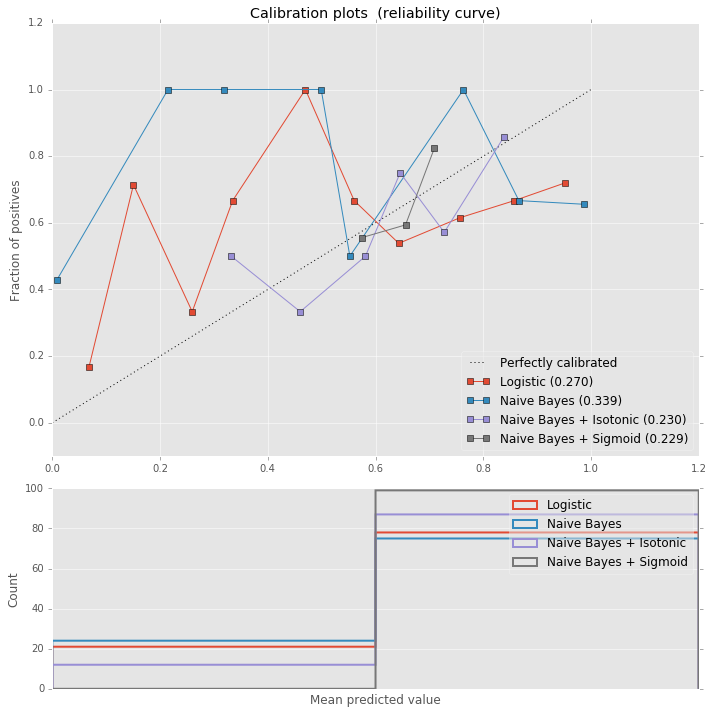

In [56]:
print(__doc__)

# Adapted from scikit learn documentation
# Original Authors: Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train_cal, y_train_cal)
        y_pred = clf.predict(X_test_cal)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test_cal)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test_cal)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test_cal, 
                                     prob_pos, pos_label='yes')
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test_cal, y_pred, pos_label='yes'))
        print("\tRecall: %1.3f" % recall_score(y_test_cal, y_pred, pos_label='yes'))
        print("\tF1: %1.3f\n" % f1_score(y_test_cal, y_pred, pos_label='yes'))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test_cal, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=2, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.1, 1.2])
    ax1.set_xlim([0,1.2])
    ax1.legend(loc='best', fancybox=True, framealpha=0.5)
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.set_xticks([2])
    ax2.legend(loc='best', fancybox=True, framealpha=0.5)

    plt.tight_layout()

# Plot calibration curve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 5)

# Plot calibration curve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 1)

# Plot calibration curve for K Nearest Neighbors Classifier
plot_calibration_curve(neighbors.KNeighborsClassifier(), "KNN", 2)

# Plot calibration curve for Decision Tree Classifier
plot_calibration_curve(tree.DecisionTreeClassifier(), "Decision Tree", 3)

plt.show()

# V. Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

## Most Appropriate Model
* *__Question 3__: Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

I would argue the best model for this dataset is a support vector machine. Of the three models I tested, the support vector machine yielded the highest F<sub>1</sub> score over all three training sizes. 

The decision tree model and K nearest neighbors classifier performed weakly in contrast to the SVM. Though the two classifiers performed faster in training in prediction, they both scored low in their respected F<sub>1</sub> scores. The Decision Tree Model can more notably be assumed to overfit the data, having an F<sub>1</sub> score of 1.0. 

As the training size grows, the SVC remains strong. While the change in F<sub>1</sub> score on the training set decreases minimally (approximately 1.5%) the change in F<sub>1</sub> score on the training set increases by approximately 4.9%, outweighing the minimal loss. 

Based on the available data, limited resources, cost, and performance I would select the SVM as the most appropriate model. A SVM is computationally efficient as the training set grows while still yielding strong results. 

Automatically created module for IPython interactive environment


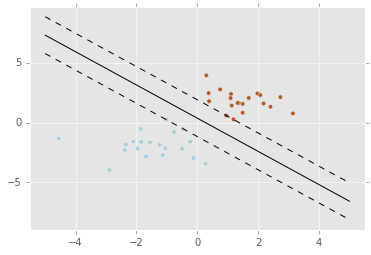

In [57]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# we create 40 separable points
np.random.seed(0)
X = np.r_[np.random.randn(20, 2) - [2, 2], np.random.randn(20, 2) + [2, 2]]
Y = [0] * 20 + [1] * 20

# fit the model
clf = svm.SVC(kernel='linear')
clf.fit(X, Y)

# get the separating hyperplane
w = clf.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(-5, 5)
yy = a * xx - (clf.intercept_[0]) / w[1]

# plot the parallels to the separating hyperplane that pass through the
# support vectors
b = clf.support_vectors_[0]
yy_down = a * xx + (b[1] - a * b[0])
b = clf.support_vectors_[-1]
yy_up = a * xx + (b[1] - a * b[0])

# plot the line, the points, and the nearest vectors to the plane
plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--')
plt.plot(xx, yy_up, 'k--')

plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=80, facecolors='none')
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)

plt.axis('tight')
plt.show()

## Model in Layman's Terms
* *__Question 4__: In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

### What is a SVM?

A support vector machine is a learning algorithm that receives data as input and outputs a function which can be used to predict future data. SVMs maximize the margin around a line (or in more than two dimensions, hyperplanes) when their are many possible solutions, therefor defining the best way to *linearly separate the data*.


In a linear function, the separator is expressed as `ax + by = c` such that:

   a<span style="color:red">x</span> + b<span style="color:red">y</span> ≥ c, for <span style="color:red">red</span> points
   
   a<span style="color:blue">x</span> + b<span style="color:blue">y</span> ≤ c, for <span style="color:blue">green</span> points
   
In the case with students passing, we are given data for a set of students. The data includes age, health, school, number of failures, etc. These attributes become features to collectively distinguish and predict aganinst the target variable which is if the student passed or not. The goal is to classify these two groups of students- those who passed and those who did not- so we can distinguish them from another and create a prediction mechanism.

Below is a modeled SVM, displaying three support vectors (credit OpenCV). 

![Support Vector Model](http://docs.opencv.org/2.4/_images/optimal-hyperplane.png)

# VI. Model Tuning

Below the chosen model is fine tuned. Using [grid search](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) (`GridSearchCV`) with at least one important parameter we use the entire training set to tune the model with at least 3 different values.

SVMs have a benefit of which they are very malleable. That is, they can easily be adjusted through parameter settings to yield better results.

In the SVM the decision boundary at work is separating the two classes: students who pass and those who fail. To better fit data and maximize the plane, we can test a variety of SVM parameters and call on `GridSearchCV` to run through them and find the optimal solution.

#### 1) We can first get the parameter keys of the SVC classifier to select parameters to tune

In [58]:
print clf_A.get_params().keys()

['kernel', 'C', 'verbose', 'probability', 'degree', 'shrinking', 'max_iter', 'decision_function_shape', 'random_state', 'tol', 'cache_size', 'coef0', 'gamma', 'class_weight']


### The parameters I originally tested were: 

- `C: [1, 10, 100, 1000]`
- `gamma: [1e-3, 1e-2]`
- `kernel: [rbf, linear, sigmoid, poly]`
- `degree: [0, 1, 2, 3]`

In [59]:
# Exhaustive search! Helps narrow down our parameters so we can tune more accurately. 
def svc_param_select(X, y):
    start = time()
    Cs = [1, 10, 100]
    gammas = [0.01, 0, 1, 0.07]
    ks = ['sigmoid', 'linear', 'rbf']
    coefs = [-100000000, -100, 0, 1, 100]
    deg = [1,2,4]
    param_grid = {'kernel': ks, 'C': Cs, 'gamma': gammas}
    grid_search = GridSearchCV(SVC(), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    end = time()
    print "Best parameters: {}\n Best estimator: {}\n Best score: {}\n".format(grid_search.best_params_,
                                                                               grid_search.best_estimator_,
                                                                              grid_search.best_score_,)
    print "Finished in {} seconds.".format(end-start)

svc_param_select(X_train, y_train)

Best parameters: {'kernel': 'rbf', 'C': 1, 'gamma': 0.07}
 Best estimator: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.07, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
 Best score: 0.722972972973

Finished in 40.9728899002 seconds.


#### Initial Evaluation 
The exhaustive evaluation showed rbf and linear kernels produced maximum results (I ran this on both the test set and training set). I further began to tune my parameters further and focus in on an rbf kernel.


#### 2) Now I can apply more precise tuning methods and an F<sub>1</sub> scoring function


Best parameters: {'kernel': 'rbf', 'C': 1.011111111111111, 'gamma': 0.09}

Best estimator: SVC(C=1.01111111111, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.09, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


Training a SVC using a training set size of 100. . .
Trained model in 					0.0014
Made predictions on training set in: 			0.0009
F1 score for training set: 				1.0000
Made predictions on test set in: 			0.0009
F1 score for test set: 					0.7799

Training a SVC using a training set size of 200. . .
Trained model in 					0.0038
Made predictions on training set in: 			0.0029
F1 score for training set: 				0.9814
Made predictions on test set in: 			0.0015
F1 score for test set: 					0.7871

Training a SVC using a training set size of 296. . .
Trained model in 					0.0078
Made predictions on training set in: 			0.0057
F1 score for training set: 				0.9736
Made prediction

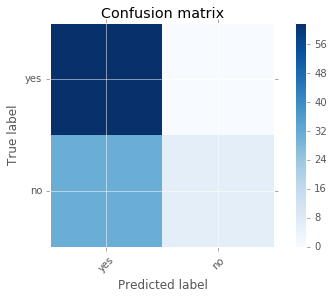

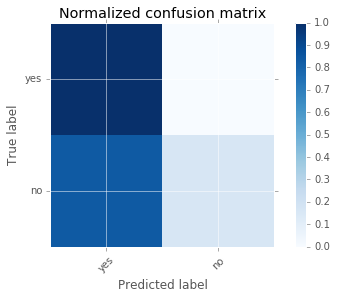

In [60]:
# Create the parameter list to tune
parameters = [{'C': [1, 0.99, 1.0001, 1.0111111111111111111111111],
               'gamma': [0.09, 0.009, 0.0999, 0.11, 0.1],
               'kernel': ['rbf']}]

# f1 scoring function using 'make_scorer'
f1_scorer = make_scorer(f1_score, pos_label='yes')

# Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(clf, parameters, f1_scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_
print "\nBest parameters: {}\n\nBest estimator: {}".format(grid_obj.best_params_,
                                                                               grid_obj.best_estimator_,)

print
clf_arr = [train_predict_noP(clf, X_train_100, y_train_100, X_test, y_test),
           train_predict_noP(clf, X_train_200, y_train_200, X_test, y_test),
           train_predict_noP(clf, X_train_300, y_train_300, X_test, y_test)]


print

# Report the final F1 score for training and testing after parameter tuning
train_pred_all(clf)

def compare_models(clf1, clf2):
    print "\t\t\t\t\t\t\tTuned Model \t\tOriginal Model\t\tDifference"
    print "Training Size"
    i=0
    sizes = 95, 195, 295
    
    while i<=2:
        
        print sizes[i]
        print "\tMade predictions on training set in: \t\t{:.4f}\t\t\t{:.4f}".format(clf1[i][1], clf2[i][1])
        print "\tChange in prediction time:\t\t\t\t\t\t\t\t\t{:.4f}%".format((clf2[i][1]-clf1[i][1])/clf2[i][1]*100)
        print "\tF1 score for training set: \t\t\t{:.4f}\t\t\t{:.4f}".format(clf1[i][2], clf2[i][2])
        print "\tChange in F1 score:\t\t\t\t\t\t\t\t\t\t{:.4f}%".format((clf1[i][1]-clf2[i][1])/clf1[i][1]*100)
        print "\tMade predictions on test set in: \t\t{:.4f}\t\t\t{:.4f}".format(clf1[i][3], clf2[i][3])
        print "\tChange in prediction time:\t\t\t\t\t\t\t\t\t{:.4f}%".format((clf2[i][1]-clf1[i][1])/clf2[i][1]*100)
        print "\tF1 score for test set: \t\t\t\t{:.4f}\t\t\t{:.4f}".format(clf1[i][4], clf2[i][4])
        print "\tChange in F1 score:\t\t\t\t\t\t\t\t\t\t{:.4f}%".format((clf1[i][1]-clf2[i][1])/clf1[i][1]*100)
        print
        i+=1

compare_models(clf_arr, clf_A_arr)

print "Tuned model has a training f1 score of {:.4f}".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing f1 score of {:.4f}".format(predict_labels(clf, X_test, y_test))

clf_report(clf)
plot_mat(clf)

## Final F<sub>1</sub> Score
* *__Question 5__: What is the final models's F<sub>1</sub> score for training and testing? How does that score compare to the untunted model?*


**Final training** F<sub>1</sub> score: 0.9736

**Final testing** F<sub>1</sub> score: 0.8000




#### Conclusion

While the F<sub>1</sub> score has **increased** from the untuned model by approximately 28%, the prediction and training time has **slowed** by approximately 39%